In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import utilities as ut


def print_image(image,title= None):
    plt.figure(figsize=[10,8])
    plt.suptitle(title)
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

def image_inversion(image):
        return (255-image)

In [3]:
def white_balance(img):
    img_float = img.astype(np.float32)

    # Compute the average value for each channel
    avg_b = np.mean(img_float[:,:,0])
    avg_g = np.mean(img_float[:,:,1])
    avg_r = np.mean(img_float[:,:,2])

    # Compute the scaling factors
    avg_gray = (avg_b + avg_g + avg_r) / 3.0
    scale_b = avg_gray / avg_b
    scale_g = avg_gray / avg_g
    scale_r = avg_gray / avg_r

    # Apply the scaling factors to each channel
    balanced_img = np.zeros_like(img_float)
    balanced_img[:,:,0] = img_float[:,:,0] * scale_b
    balanced_img[:,:,1] = img_float[:,:,1] * scale_g
    balanced_img[:,:,2] = img_float[:,:,2] * scale_r

    # Clip the values to the valid range [0, 255]
    balanced_bgr_img = np.clip(balanced_img, 0, 255).astype(np.uint8)
    
    return balanced_bgr_img

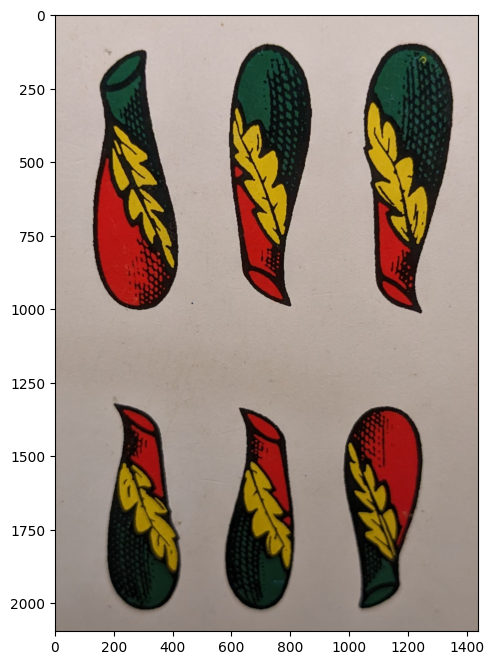

In [4]:
#Since the automatic white balance of the google camera app isn't 
#reliable, there is the need to do it manually
image_test_white_balance = cv2.imread("Images/DatasetCropped/6B-6.jpg")
print_image(image_test_white_balance)

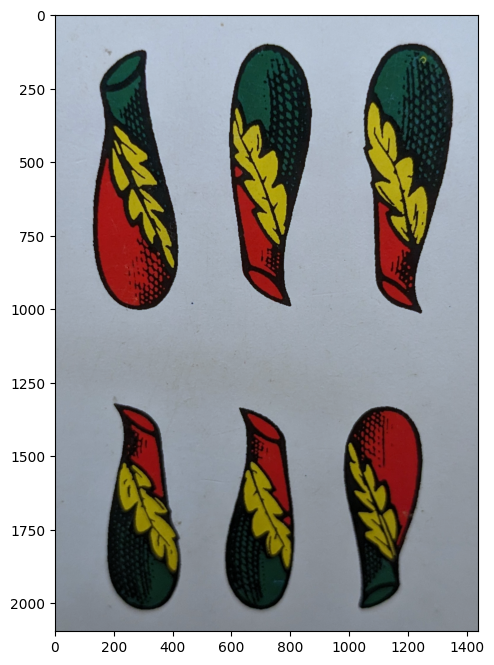

In [5]:
image_test_white_balance = white_balance(image_test_white_balance)
print_image(image_test_white_balance)

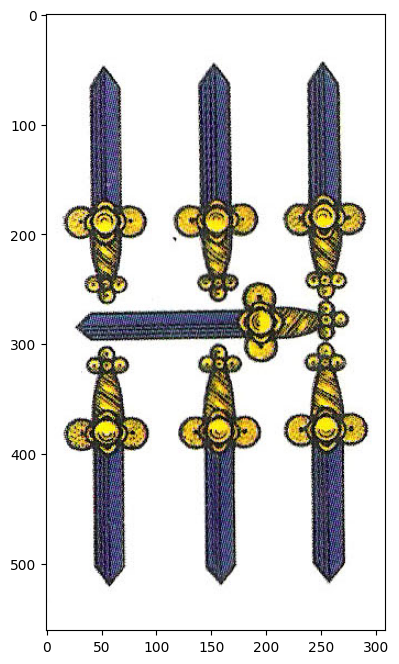

In [6]:
image = cv2.imread('Images/Cards/7S.jpg')
print_image(image)

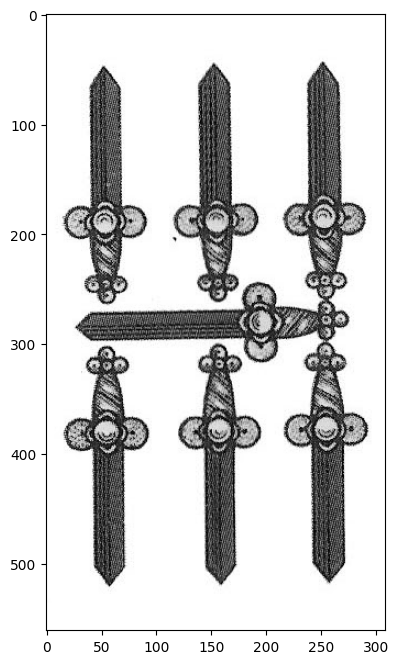

In [7]:
#for countour extraction, color are useless
gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
print_image(gray_image)

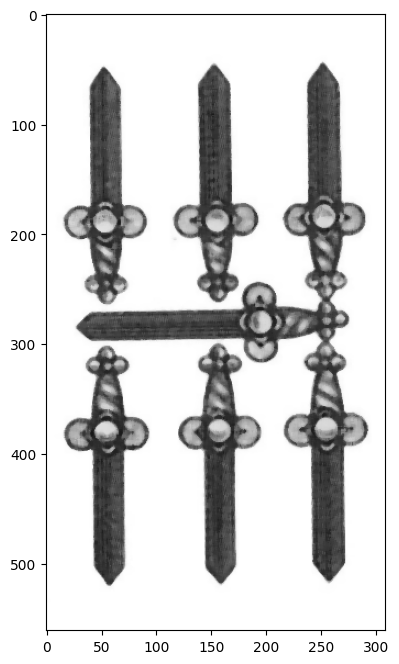

In [8]:
#Median blur was used to limit the impact of dust specs and general imperfection
#on the image
median_image = cv2.medianBlur(gray_image,5)
print_image(median_image)


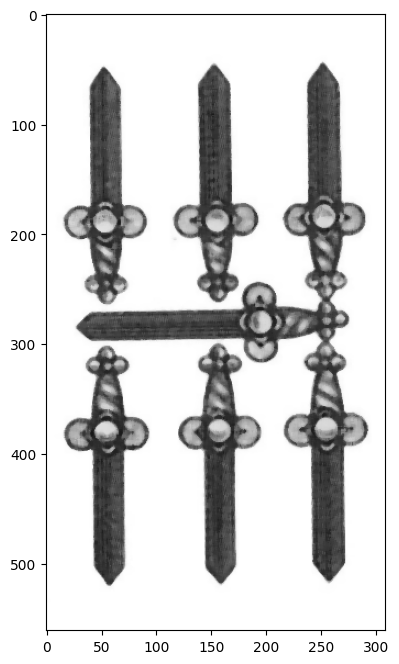

In [9]:
#Applied a filter to enhance contrast
img_contrasty_post_median = cv2.convertScaleAbs(median_image, 1.9, 1)
print_image(img_contrasty_post_median)


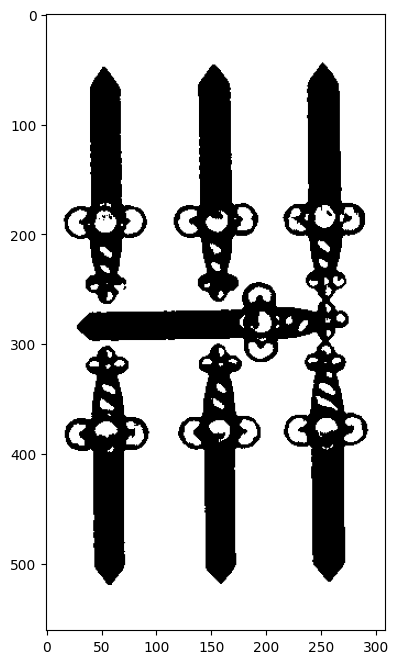

In [10]:
#Since the high contrast between background and object White against figures, and
#in the card detection, we can use a pretty leniant thresholding, low bound to the assignment of 1 pixels
th, binary_image = cv2.threshold(img_contrasty_post_median, 155, 255, cv2.THRESH_BINARY)
print_image(binary_image)



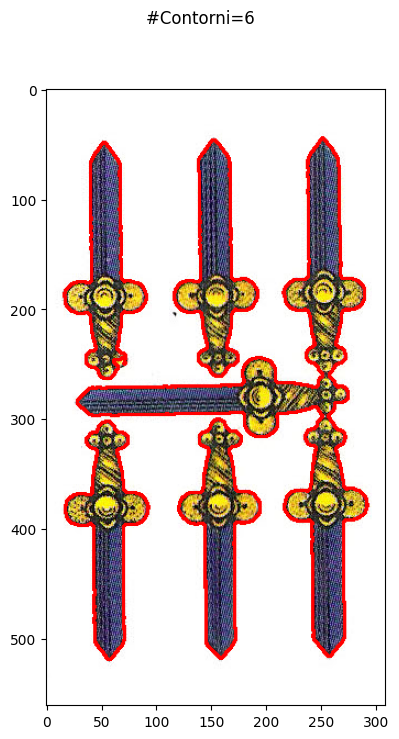

In [11]:
#find contours works on black background images so i need to invert the image
contours, _ = cv2.findContours(image_inversion(binary_image), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#Create a copy of the original image to draw on
image_with_contours = image.copy()

cv2.drawContours(image_with_contours, contours, -1, (0, 0, 255), 2)  # You can adjust the color and thickness
print_image(image_with_contours,"#Contorni={} ".format(str(len(contours))))
#In this case of the 7 Swords card, the center sword and the 2 on th right
#are too close toghether and are identified as a unique shape.
#This is taken as an advantage in the classifier since it is totally different by the unique shapes.

In [12]:
#conversion on the 
moments = cv2.moments(contours[0])
hu_moments = cv2.HuMoments(moments).flatten()
print(hu_moments)

[ 4.72613896e-01  1.79265834e-01  7.29025398e-03  4.46469226e-03
  2.54681849e-05  1.88988533e-03 -4.25588563e-07]


In [13]:

areas = []
ordered_contours = sorted(contours, key=cv2.contourArea, reverse=True)

#Get contours ordered by area, since the figures ones have the biggest areas
for contour in ordered_contours:
    x, y, w, h = cv2.boundingRect(contour)
    areas.append(w * h)


print('Areas:', areas)

Areas: [125345, 16632, 16786, 16425, 16416, 9]


Average Hue: 77.0120115974044


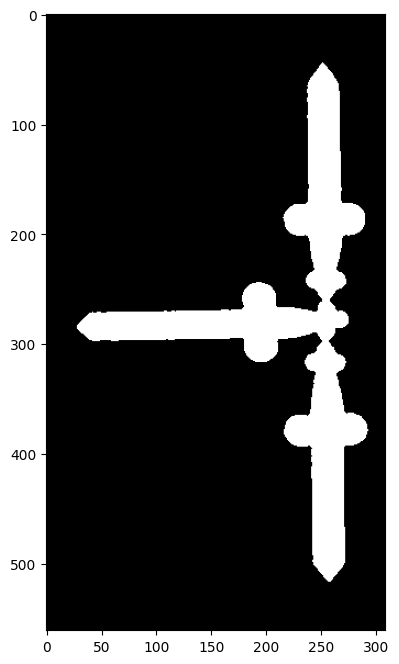

In [14]:
mask = np.zeros((image.shape[0],image.shape[1],), np.uint8)
cv2.drawContours(mask, [ordered_contours[0]], -1, 255, -1)
print_image(mask)
#To find the average color of the figure, it's easier to convert
#the image from rgb space tu the HSV space, since there is only a value
#of the space to take account instead of 3
HUE_image = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Calculate the average hue within the masked region
total_hue = 0
pixel_count = 0

for contour in contours:
    # Calculate the average hue for each contour
    area = cv2.contourArea(contour)
    if area > 0:
        mask_roi = np.zeros_like(mask)
        cv2.drawContours(mask_roi, [contour], 0, 255, -1)
        hue_values = HUE_image[..., 0][mask_roi == 255]
        total_hue += np.sum(hue_values)
        pixel_count += len(hue_values)

# Calculate the average hue
if pixel_count > 0:
    average_hue = total_hue / pixel_count
    print("Average Hue:", average_hue)
else:
    print("No pixels found in the masked region.")
